In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
import os
from data_fonemas import *
from scipy.interpolate import interp1d
from IPython.display import Audio, display
# from data_fonemas import coef_a, coef_b
# from scipy.signal import lfilter
# from data_fonemas import suavizar_bordes, gen_pulsos, coef_a, coef_b

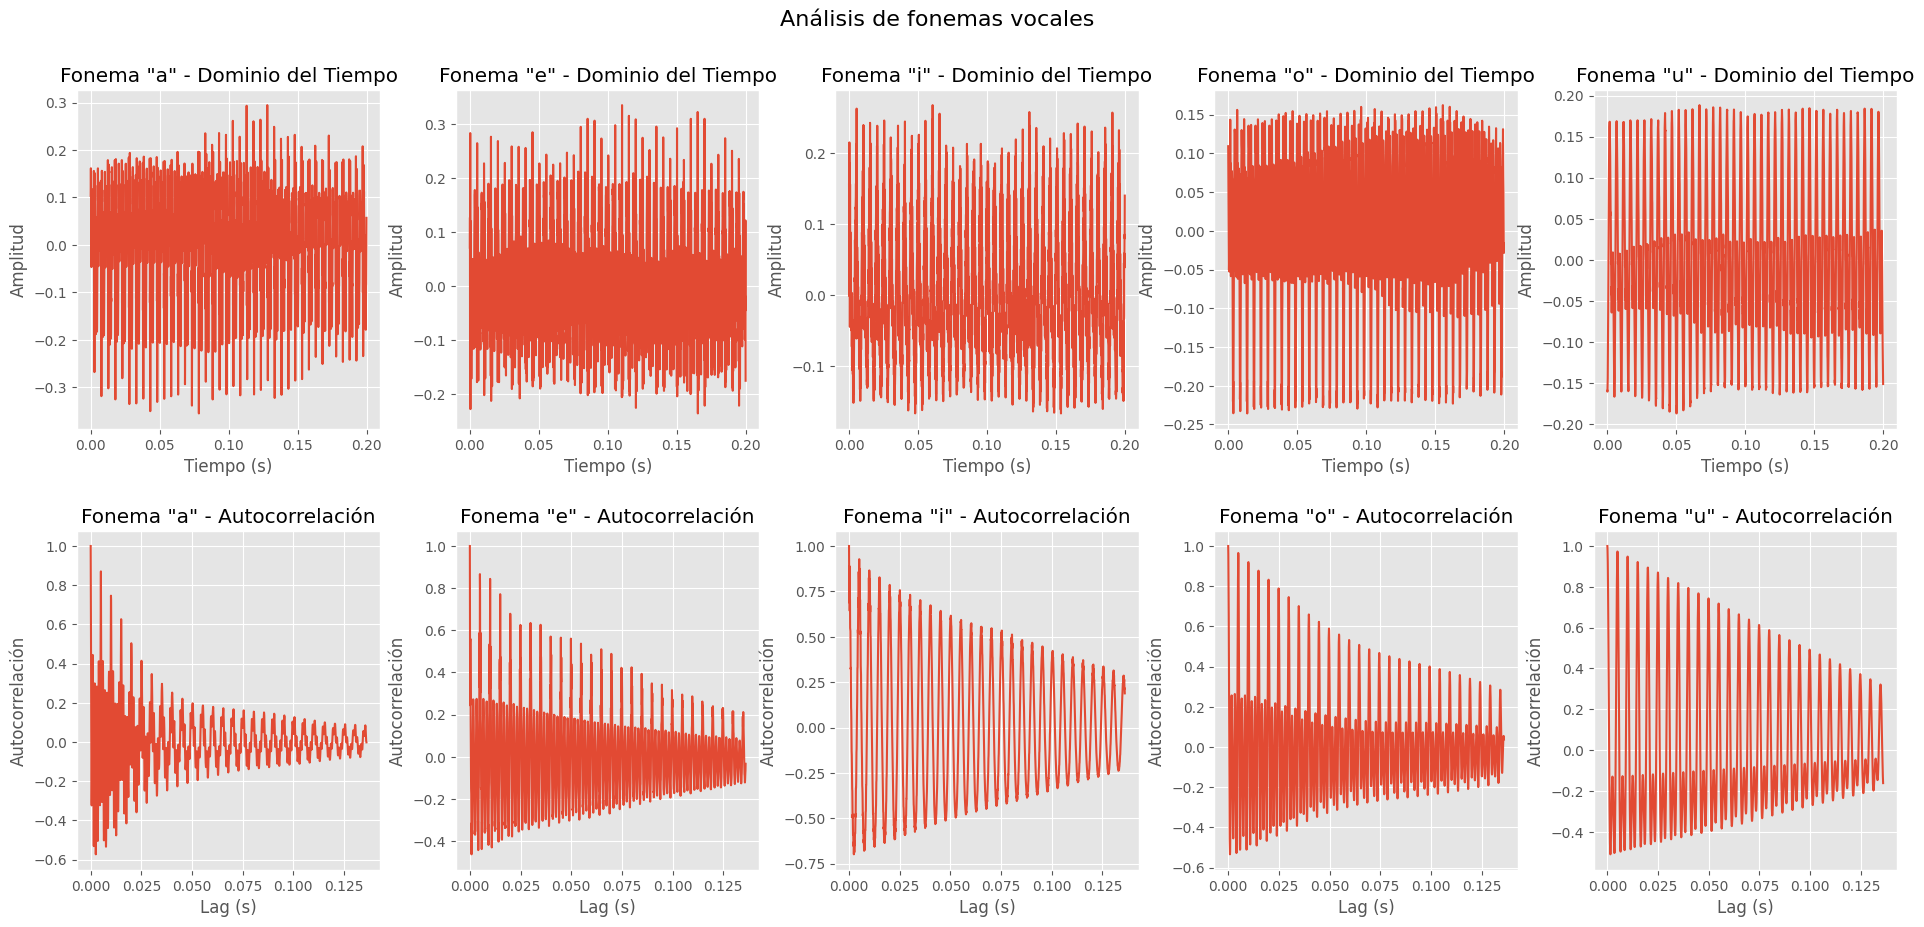

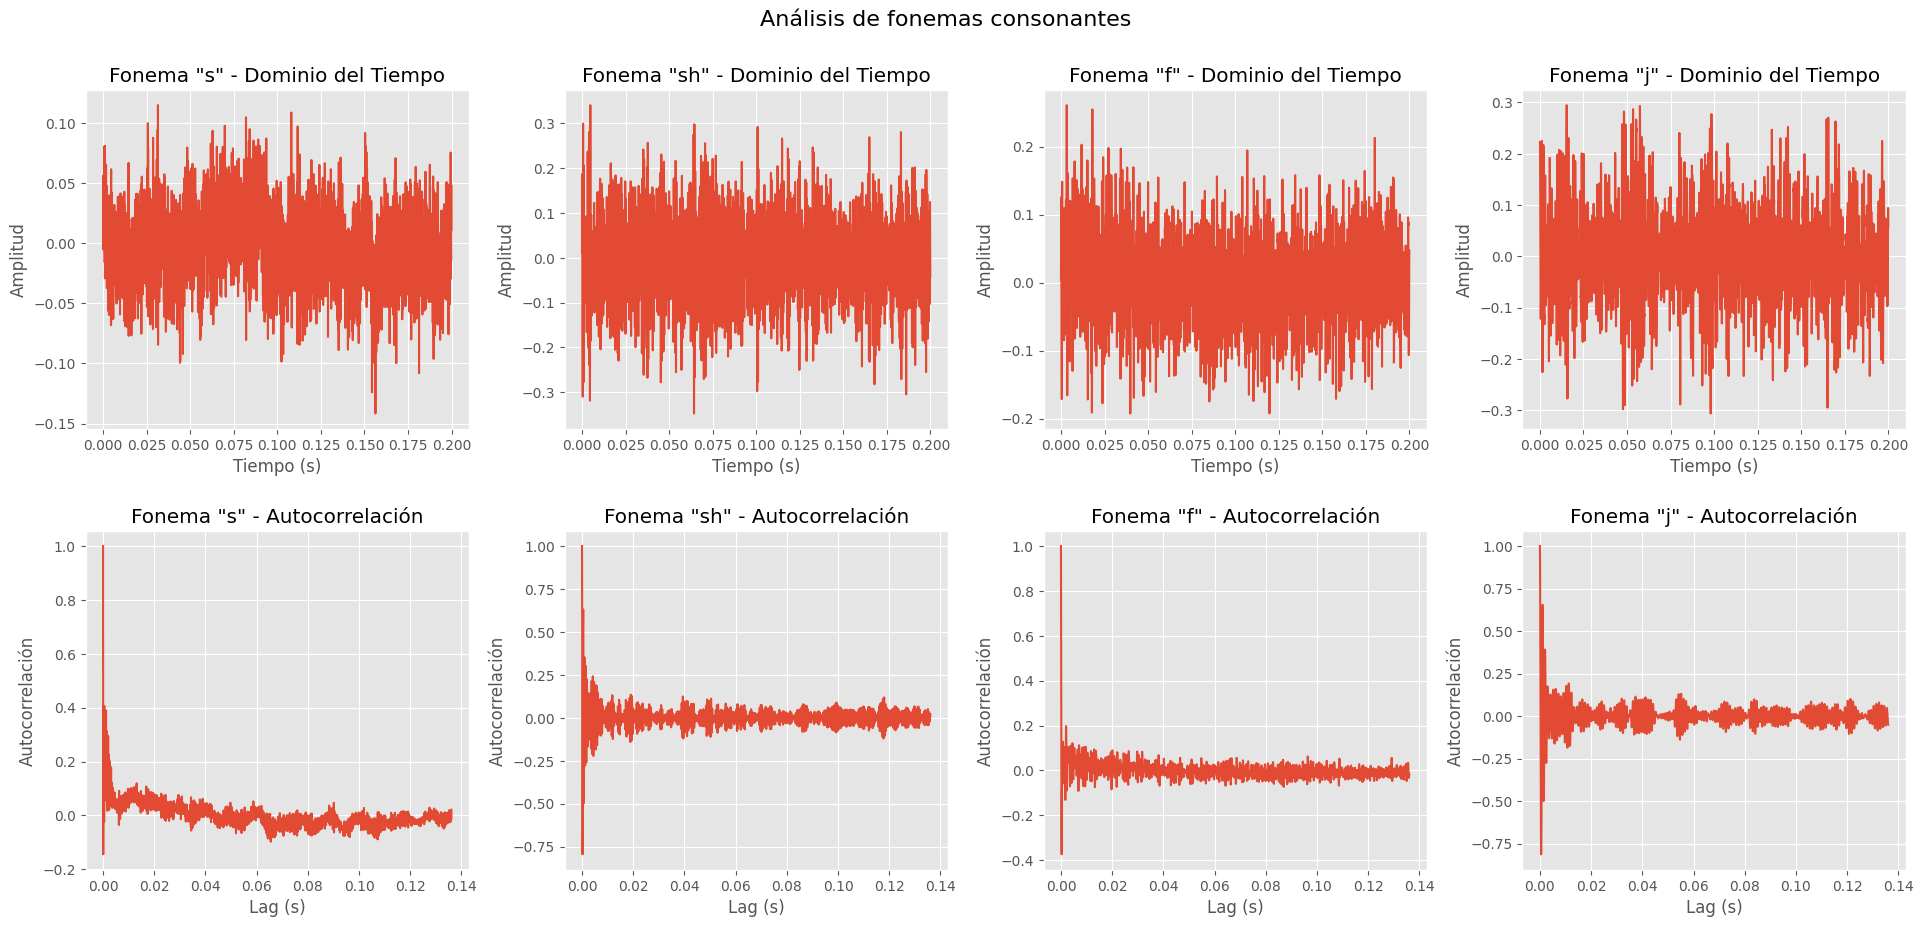

In [5]:
# Ejercicio 1: Análisis del modelo
# a.

plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('ggplot')

audio_path = "./audios/"

vocales = ['a', 'e', 'i', 'o', 'u']
consonantes = ['s', 'sh', 'f', 'j']
fonemas = vocales + consonantes

def autocorrelacion(x, lagmax=None):
    n = len(x)
    if lagmax is None:
        lagmax = n
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')
    r = r[n-1:n+lagmax]
    return r / r[0]

fig_vocales, axs_vocales = plt.subplots(2, len(vocales), figsize=(20, 10))
fig_vocales.suptitle('Análisis de fonemas vocales', fontsize=16)

fig_consonantes, axs_consonantes = plt.subplots(2, len(consonantes), figsize=(20, 10))
fig_consonantes.suptitle('Análisis de fonemas consonantes', fontsize=16)

duracion = 0.2  # 200ms duración de la muestra

for i, fonema in enumerate(fonemas):
    filename = f"{audio_path}{fonema}.wav"
    try:
        audio, fs = sf.read(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        continue
    
    mitad_del_audio = len(audio) // 2
    samples = int(duracion * fs)
    segmento = audio[mitad_del_audio - samples//2:mitad_del_audio + samples//2]
    
    t = np.arange(len(segmento)) / fs
    
    # autocorrelación
    acorr = autocorrelacion(segmento, lagmax=min(2000, len(segmento)))
    lag_time = np.arange(len(acorr)) / fs
    
    if fonema in vocales:
        ax_time = axs_vocales[0, vocales.index(fonema)]
        ax_acorr = axs_vocales[1, vocales.index(fonema)]
    else:
        ax_time = axs_consonantes[0, consonantes.index(fonema)]
        ax_acorr = axs_consonantes[1, consonantes.index(fonema)]
    
    ax_time.plot(t, segmento)
    ax_time.set_title(f'Fonema "{fonema}" - Dominio del Tiempo')
    ax_time.set_xlabel('Tiempo (s)')
    ax_time.set_ylabel('Amplitud')
    
    ax_acorr.plot(lag_time, acorr)
    ax_acorr.set_title(f'Fonema "{fonema}" - Autocorrelación')
    ax_acorr.set_xlabel('Lag (s)')
    ax_acorr.set_ylabel('Autocorrelación')

plt.tight_layout()
fig_vocales.subplots_adjust(top=0.9, bottom=0.12, left=0.07, right=0.98, hspace=0.3, wspace=0.25)
fig_consonantes.subplots_adjust(top=0.9, bottom=0.12, left=0.07, right=0.98, hspace=0.3, wspace=0.25)
plt.show()

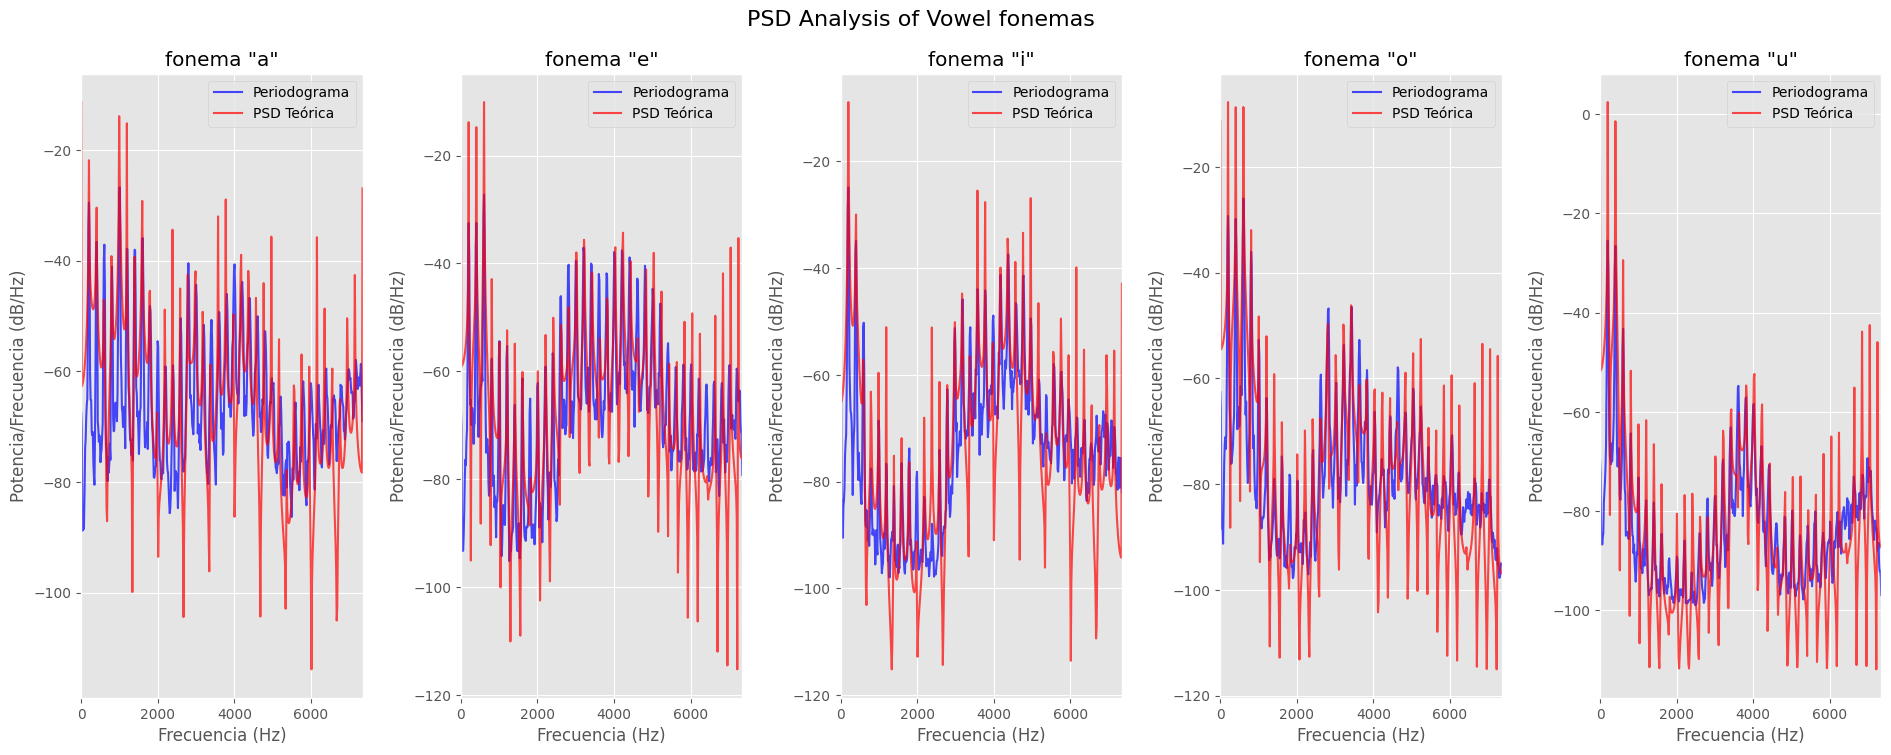

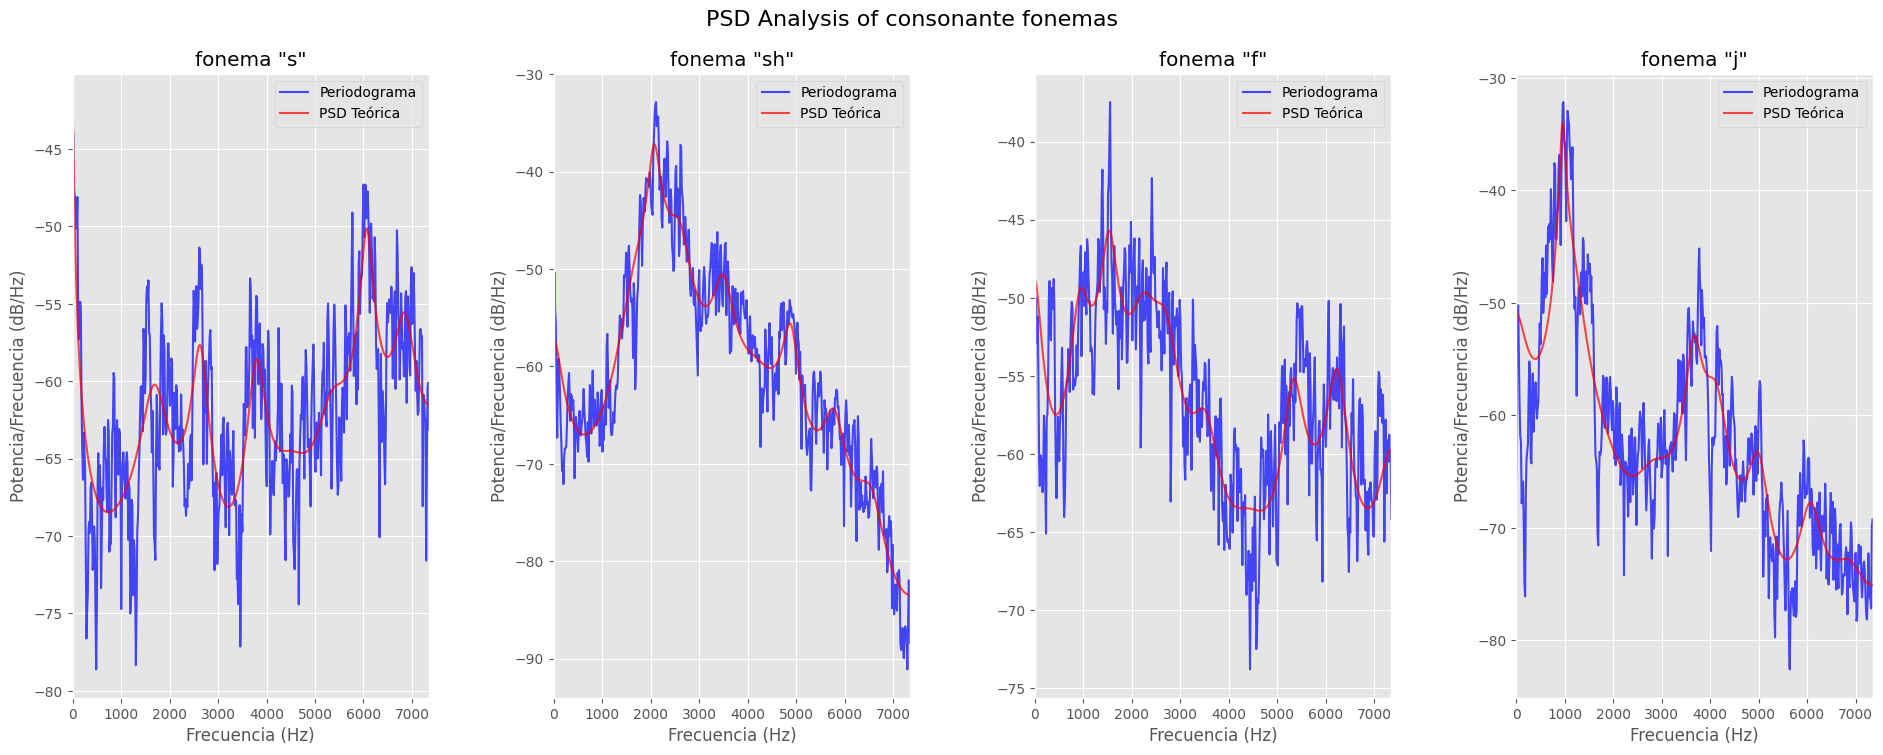

In [6]:
# Ejercicio 1: Análisis de fonemas
# b.

fs = 14700

# PSD Teórica
def psd_teo(a_coef, b_coef, f, fs, fonema_type='consonante', tono=None):
    w = 2 * np.pi * f / fs
    
    b_scalar = b_coef[0]
    
    z = np.exp(-1j * w)
    H = np.zeros_like(f, dtype=complex)
    for i in range(len(f)):
        denominator = 1
        for j, a in enumerate(a_coef):
            denominator -= a * z[i]**(j+1)
        H[i] = b_scalar / denominator
    
    if fonema_type == 'consonante':
        S_X = np.abs(H)**2
    else:
        N = 8192
        pulso_psd, pulso_freqs = psd_pulsos(tono, N, fs)
        
        func_interpol = interp1d(
            pulso_freqs, 
            pulso_psd, 
            kind='linear', 
            bounds_error=False, 
            fill_value=0
        )
        S_U = func_interpol(f)
        S_X = np.abs(H)**2 * S_U
    
    return S_X

fig_psd_vocales, axs_psd_vocales = plt.subplots(1, len(vocales), figsize=(20, 8))
fig_psd_vocales.suptitle('PSD Analysis of Vowel fonemas', fontsize=16)

fig_psd_consonantes, axs_psd_consonantes = plt.subplots(1, len(consonantes), figsize=(20, 8))
fig_psd_consonantes.suptitle('PSD Analysis of consonante fonemas', fontsize=16)

duracion = 0.2

for fonema in fonemas:
    filename = f"{audio_path}{fonema}.wav"
    try:
        audio, fs = sf.read(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        continue
    
    mitad_del_audio = len(audio) // 2
    samples = int(duracion * fs)
    segmento = audio[mitad_del_audio - samples//2:mitad_del_audio + samples//2]
    
    window = np.hanning(len(segmento))
    windowed_segmento = segmento * window
    
    f_welch, Pxx_welch = signal.welch(windowed_segmento, fs=fs, nperseg=1024, noverlap=512, scaling='spectrum')
    
    Pxx_db = 10 * np.log10(Pxx_welch + 1e-10)
    
    a_coefs = coef_a[fonema]
    b_coef = coef_b[fonema]
    
    if fonema in vocales:
        acorr = autocorrelacion(segmento, lagmax=min(2000, len(segmento)))
        exclude_samples = 20
        peak_idx = exclude_samples + np.argmax(acorr[exclude_samples:min(1000, len(acorr))])
        tono_estimado = fs / peak_idx if peak_idx > 0 else 100
        
        S_X_teo = psd_teo(a_coefs, b_coef, f_welch, fs, fonema_type='vowel', tono=tono_estimado)
    else:
        S_X_teo = psd_teo(a_coefs, b_coef, f_welch, fs, fonema_type='consonante')
    
    S_X_teo_db = 10 * np.log10(S_X_teo + 1e-10)
    
    scale_factor = np.mean(Pxx_db) - np.mean(S_X_teo_db)
    S_X_teo_db += scale_factor
    
    if fonema in vocales:
        ax = axs_psd_vocales[vocales.index(fonema)]
    else:
        ax = axs_psd_consonantes[consonantes.index(fonema)]
    
    ax.plot(f_welch, Pxx_db, 'b-', alpha=0.7, label='Periodograma')
    ax.plot(f_welch, S_X_teo_db, 'r-', alpha=0.7, label='PSD Teórica')
    
    ax.set_xlim(0, fs/2)
    
    ax.set_title(f'fonema "{fonema}"')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Potencia/Frecuencia (dB/Hz)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
fig_psd_vocales.subplots_adjust(top=0.9, bottom=0.12, left=0.08, right=0.98, wspace=0.35)
fig_psd_consonantes.subplots_adjust(top=0.9, bottom=0.12, left=0.08, right=0.98, wspace=0.35)
plt.show()

Filter unstable for a, using alternative approach
Filter unstable for e, using alternative approach
Filter unstable for i, using alternative approach
Filter unstable for o, using alternative approach
Filter unstable for u, using alternative approach
Filter unstable for sh, using alternative approach
Filter unstable for j, using alternative approach


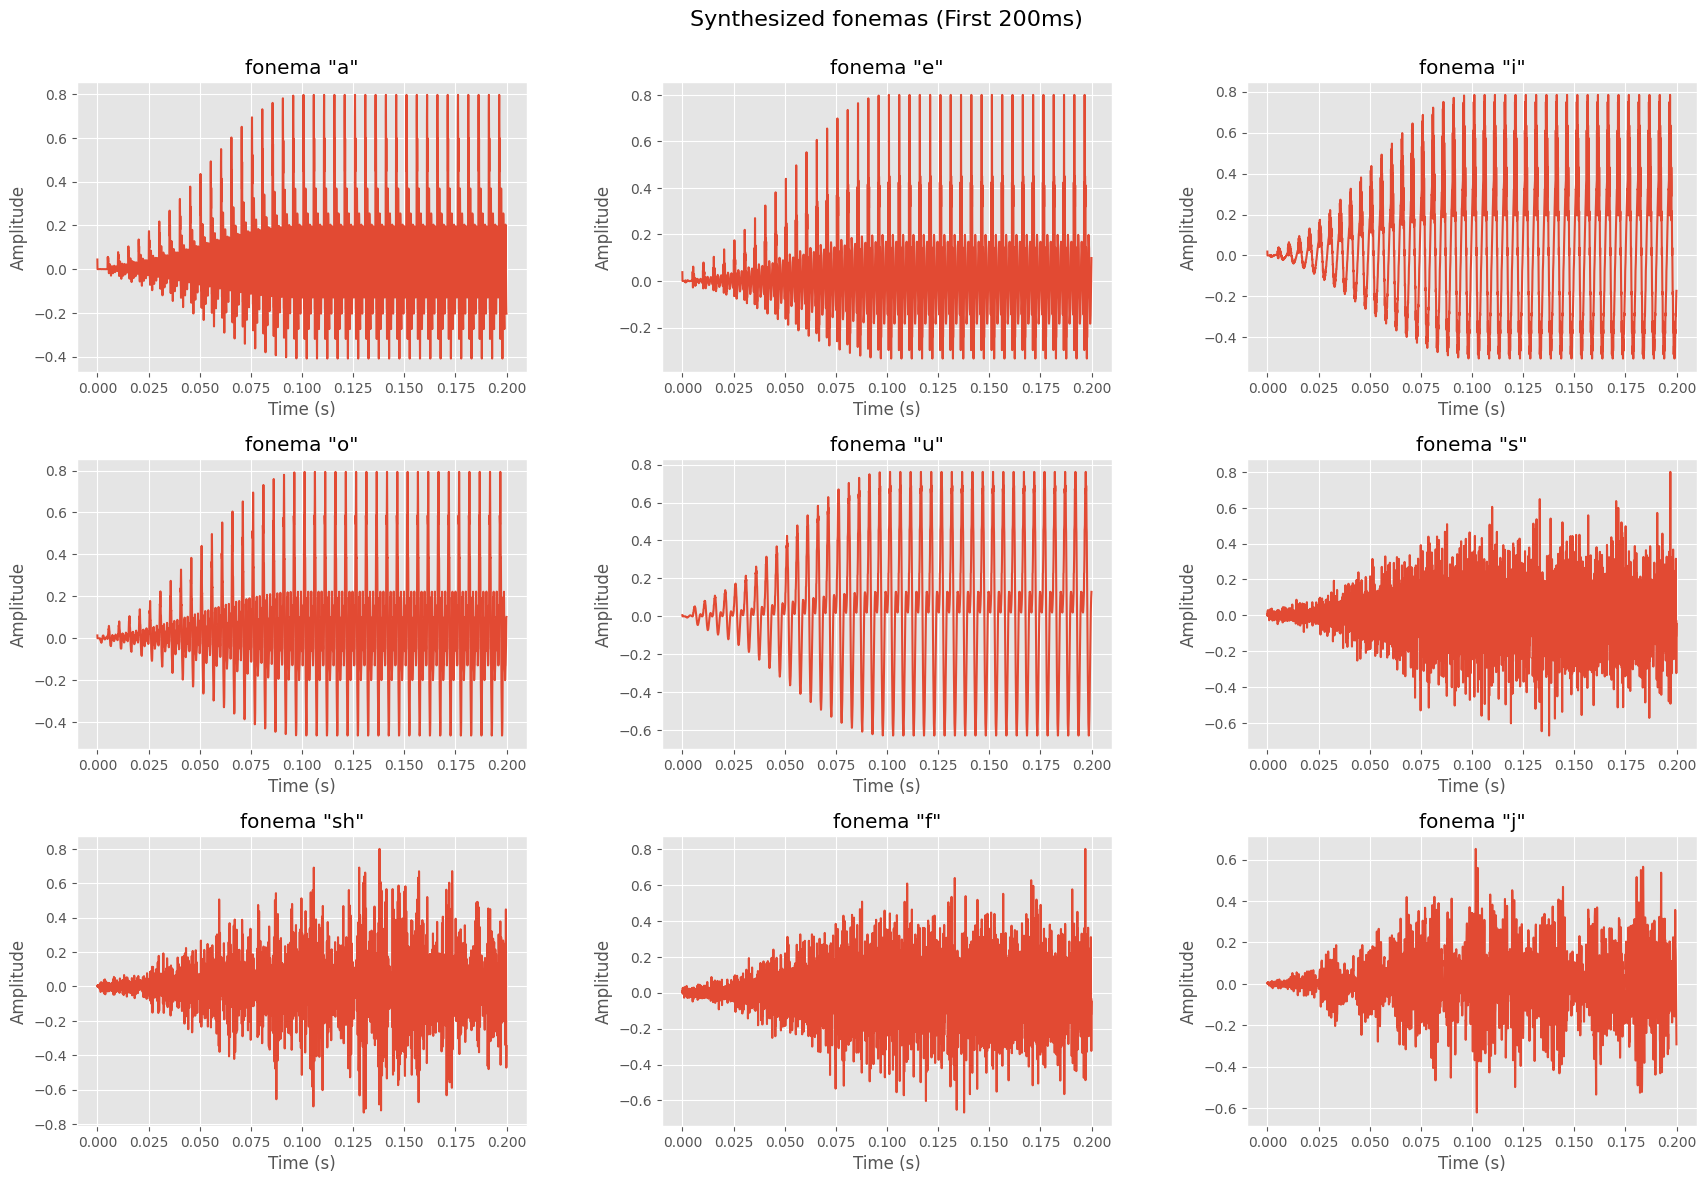

In [7]:
# fonema Synthesis - Exercise 2 with fixed 's' and 'f' synthesis
fs = 14700  # Sampling Frecuencia (Hz)
duracion = 0.5  # 500 ms
N = int(fs * duracion)  # Number of samples
f0 = 200  # Fundamental Frecuencia for vocales (Hz)

# Dictionary to store synthesized fonemas
synthesized_fonemas = {}

# Create a figure to plot the synthesized fonemas
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Synthesized fonemas (First 200ms)', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through all fonemas
for i, fonema in enumerate(fonemas):
    if i >= len(axs):  # Ensure we don't exceed available axes
        print(f"Warning: Not enough axes for fonema {fonema}")
        continue
        
    # Get AR coefficients
    coef_afs = coef_a[fonema]
    coef_bf = coef_b[fonema][0]  # Extract scalar value from list
    
    # Create excitation signal based on fonema type
    if fonema in vocales:
        # For vocales: use pulse train
        excitation = gen_pulsos(f0, N, fs)
    else:
        # For consonantes: use white noise
        np.random.seed(42)  # Set seed for reproducibility
        excitation = np.random.randn(N)
    
    # Special handling for problematic fonemas 's' and 'f'
    if fonema in ['s', 'f']:
        # Use a modified approach for these unstable fonemas
        try:
            # Get spectral envelope from coefficients (evaluate at Frecuencia points)
            nfft = 512
            w, h = signal.freqz([coef_bf], [1.0] + coef_afs, worN=nfft)
            
            # Create a new noise signal
            np.random.seed(42)  # For reproducibility
            noise = np.random.randn(N)
            
            # Apply spectral shaping in Frecuencia domain
            noise_fft = np.fft.rfft(noise)
            freq_bins = min(len(noise_fft), nfft//2+1)
            
            # Interpolate the Frecuencia response to match FFT bins
            from scipy.interpolate import interp1d
            f_normalized = w / np.pi
            mag_response = np.abs(h)
            
            # Ensure we have valid values
            valid_indices = ~np.isnan(mag_response) & ~np.isinf(mag_response)
            if np.sum(valid_indices) > 1:
                f_valid = f_normalized[valid_indices]
                mag_valid = mag_response[valid_indices]
                
                # Create interpolation function (with bounds checking)
                func_interpol = interp1d(
                    f_valid, mag_valid, 
                    bounds_error=False, 
                    fill_value=(mag_valid[0], mag_valid[-1])
                )
                
                # Generate target Frecuencia points (0 to 1)
                target_freqs = np.linspace(0, 1, freq_bins)
                
                # Get filter shape at those frequencies
                filter_shape = func_interpol(target_freqs)
                
                # Apply filter shape to noise spectrum (with safety checks)
                filter_shape = np.clip(filter_shape, 0, 10)  # Prevent extreme values
                noise_fft[:freq_bins] *= filter_shape
                
                # Convert back to time domain
                synthesized = np.fft.irfft(noise_fft, n=N)
            else:
                # Fallback if interpolation fails
                synthesized = signal.lfilter([coef_bf], [1.0], noise)
                
            # Normalize the result
            synthesized = synthesized / (np.max(np.abs(synthesized)) + 1e-10) * 0.8
            
        except Exception as e:
            print(f"Error in spectral approach for {fonema}, using simpler alternative: {str(e)}")
            # Even simpler fallback: band-pass filtered noise
            if fonema == 's':
                # 's' is typically higher Frecuencia (4000-8000 Hz)
                synthesized = signal.butter_bandpass_filter(excitation, 4000, 8000, fs, order=4)
            else:  # 'f'
                # 'f' has energy in mid-high frequencies (2000-6000 Hz)
                synthesized = signal.butter_bandpass_filter(excitation, 2000, 6000, fs, order=4)
            
            # Normalize
            synthesized = synthesized / (np.max(np.abs(synthesized)) + 1e-10) * 0.8
    else:
        # Use the original approach for other fonemas
        try:
            # Apply AR model using filter with stability protection
            a_full = np.concatenate(([1.0], coef_afs))
            synthesized = signal.lfilter([coef_bf], a_full, excitation)
            
            # Check for instability or overflow
            if not np.all(np.isfinite(synthesized)):
                print(f"Filter unstable for {fonema}, using alternative approach")
                
                # Alternative approach: apply filter manually with stability protection
                synthesized = np.zeros(N)
                # Set initial values
                for n in range(min(20, N)):
                    synthesized[n] = coef_bf * excitation[n]
                
                # Apply recursive filter with amplitude limiting
                for n in range(20, N):
                    synthesized[n] = coef_bf * excitation[n]
                    for j, a in enumerate(coef_afs):
                        if n-j-1 >= 0:  # Ensure we don't go out of bounds
                            synthesized[n] += a * synthesized[n-j-1]
                    # Limit extreme values
                    synthesized[n] = np.clip(synthesized[n], -100, 100)
            
            # Normalize the signal
            if np.max(np.abs(synthesized)) > 0:
                synthesized = 0.8 * synthesized / np.max(np.abs(synthesized))
                
        except Exception as e:
            print(f"Error processing fonema {fonema}: {str(e)}")
            synthesized = np.zeros(N)
            
    # Smooth the edges with 20% transition (for all fonemas)
    synthesized = suavizar_bordes(synthesized, fade=20)
    
    # Store the synthesized fonema
    synthesized_fonemas[fonema] = synthesized
    
    # Check for valid data before plotting
    if not np.all(np.isfinite(synthesized[:int(0.2*fs)])):
        print(f"Warning: Invalid data in synthesized {fonema}, cleaning before plotting")
        plotting_data = np.nan_to_num(synthesized[:int(0.2*fs)], nan=0.0, posinf=0.0, neginf=0.0)
        plotting_data = np.clip(plotting_data, -1, 1)  # Ensure reasonable plot range
    else:
        plotting_data = synthesized[:int(0.2*fs)]
        
    # Display first 200ms of synthesized fonema
    display_samples = int(0.2 * fs)  # 200ms of samples
    t = np.arange(display_samples) / fs  # Time vector for first 200ms
    
    axs[i].plot(t, plotting_data)
    axs[i].set_title(f'fonema "{fonema}"')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

# Adjust layout safely without tight_layout
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Save the synthesized fonemas to wav files
output_dir = "./synthesized/"
os.makedirs(output_dir, exist_ok=True)

for fonema, audio in synthesized_fonemas.items():
    # Ensure we have valid data before saving
    valid_audio = np.nan_to_num(audio, nan=0.0, posinf=0.0, neginf=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)  # Prevent clipping in audio
    sf.write(f"{output_dir}{fonema}_synth.wav", valid_audio, fs)

Filter unstable for a, using alternative approach
Filter unstable for e, using alternative approach
Filter unstable for i, using alternative approach
Filter unstable for o, using alternative approach
Filter unstable for u, using alternative approach
Filter unstable for sh, using alternative approach
Filter unstable for j, using alternative approach


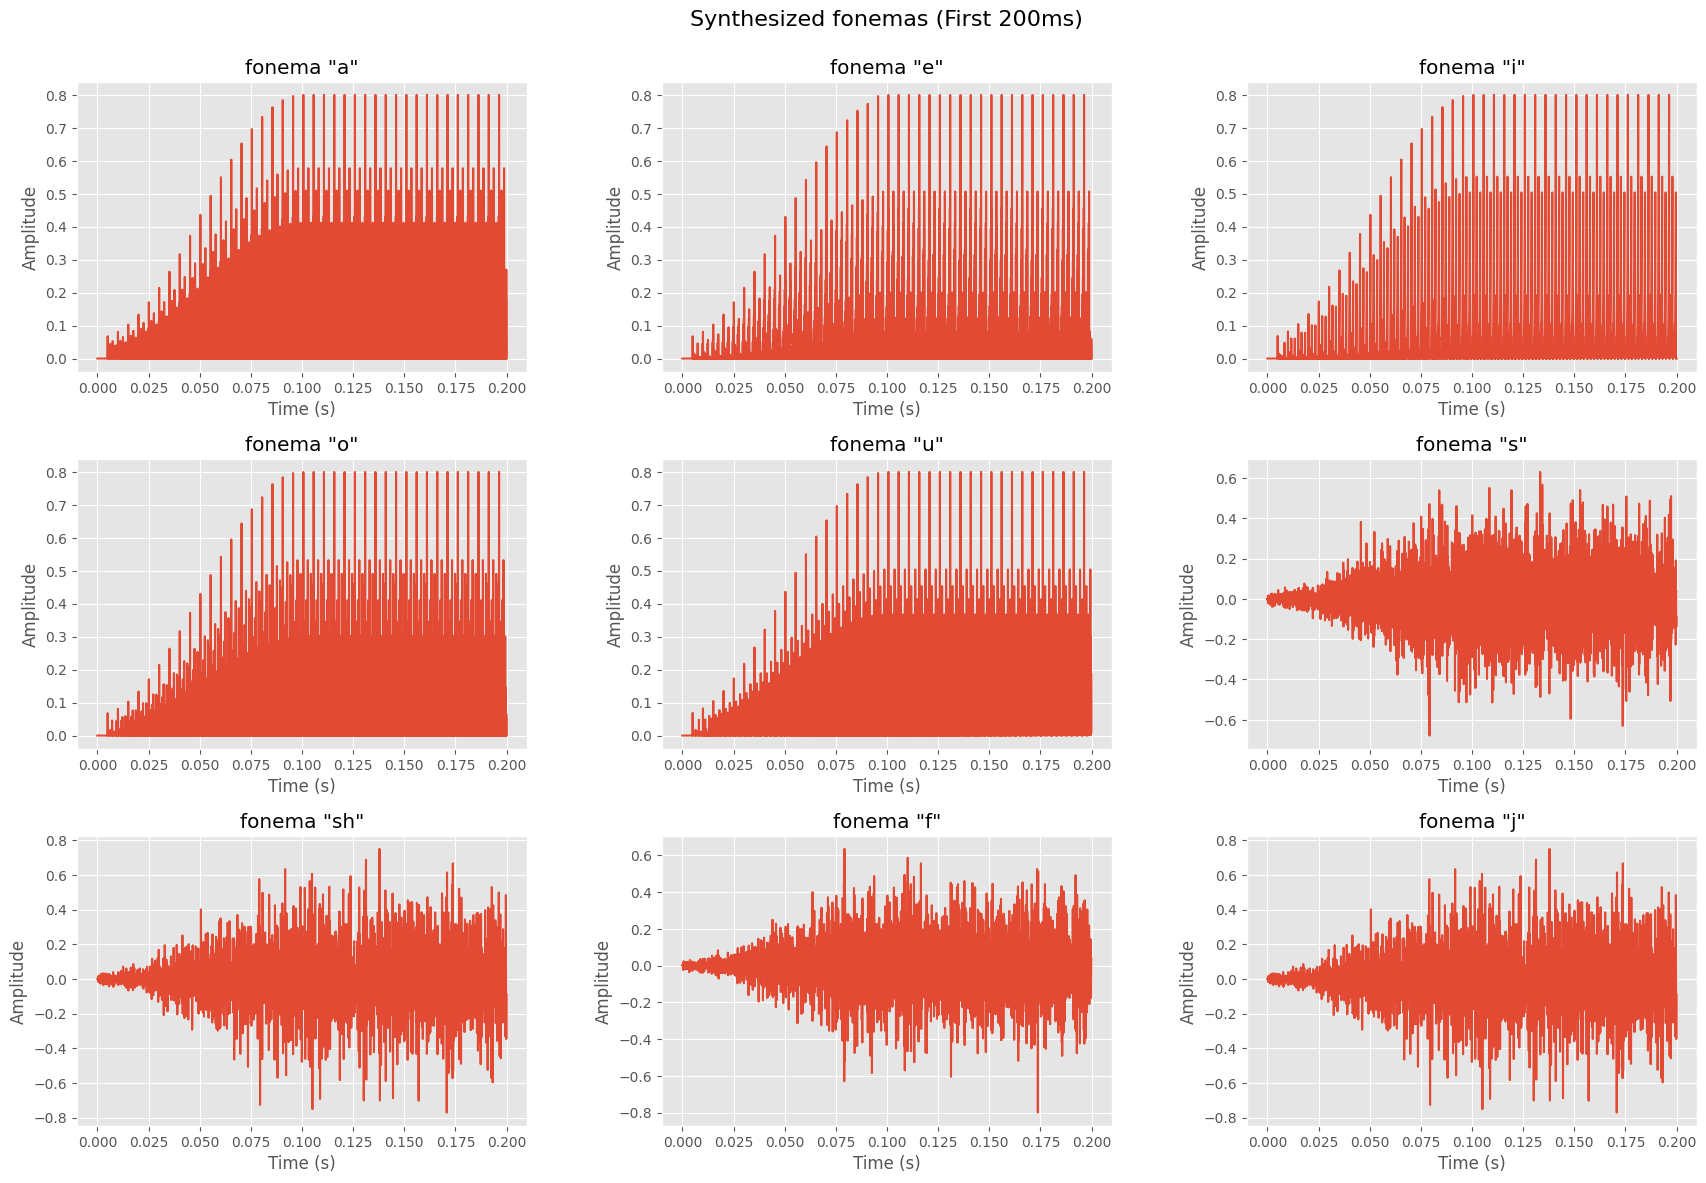

In [8]:
# Simplified implementation for Exercise 2 - fonema Synthesis
fs = 14700  # Sampling Frecuencia (Hz)
duracion = 0.5  # 500 ms
N = int(fs * duracion)  # Number of samples
f0 = 200  # Fundamental Frecuencia for vocales (Hz)

# Corrected version of the bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter with safety checks for Nyquist limit"""
    nyquist = 0.5 * fs
    
    # Ensure cutoff frequencies don't exceed Nyquist
    lowcut = min(lowcut, 0.98 * nyquist)
    highcut = min(highcut, 0.98 * nyquist)
    
    # Normalize frequencies to [0, 1] range
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Ensure we have proper ordering
    if high <= low:
        high = min(0.98, low + 0.1)
    
    # Create and apply filter
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data)
    return y
# Dictionary to store synthesized fonemas
synthesized_fonemas = {}

# Create a figure to plot the synthesized fonemas
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Synthesized fonemas (First 200ms)', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through all fonemas
for i, fonema in enumerate(fonemas):
    if i >= len(axs):  # Ensure we don't exceed available axes
        print(f"Warning: Not enough axes for fonema {fonema}")
        continue
        
    # Get AR coefficients
    coef_afs = coef_a[fonema]
    coef_bf = coef_b[fonema][0]  # Extract scalar value from list
    
    # Create excitation signal based on fonema type
    if fonema in vocales:
        # For vocales: use pulse train
        excitation = gen_pulsos(f0, N, fs)
    else:
        # For consonantes: use white noise
        np.random.seed(42)  # Set seed for reproducibility
        excitation = np.random.randn(N)
    
    # Special direct handling for 's' and 'f' fonemas
    if fonema == 's':
        # For 's': use filtered noise in high Frecuencia range (stay below Nyquist)
        synthesized = butter_bandpass_filter(excitation, 3500, 7000, fs)
        # Add some lower Frecuencia energy for better character
        mid_freq_component = butter_bandpass_filter(excitation, 1500, 3000, fs) * 0.3
        synthesized += mid_freq_component
    elif fonema == 'f':
        # For 'f': use filtered noise with broader spectrum (stay below Nyquist)
        synthesized = butter_bandpass_filter(excitation, 1500, 6000, fs)
        # Add specific formants to give 'f' character
        formant1 = butter_bandpass_filter(excitation, 1000, 1500, fs) * 0.6
        formant2 = butter_bandpass_filter(excitation, 3000, 5000, fs) * 0.7
        synthesized = 0.5*synthesized + formant1 + formant2
    else:
        # For all other fonemas, use standard AR filtering
        try:
            # Apply AR model using filter
            a_full = np.concatenate(([1.0], coef_afs))
            synthesized = signal.lfilter([coef_bf], a_full, excitation)
            
            # Check for instability
            if not np.all(np.isfinite(synthesized)):
                print(f"Filter unstable for {fonema}, using alternative approach")
                # Create a simplified version using formant filtering
                if fonema in vocales:
                    # Apply formant filters based on vowel characteristics
                    f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[fonema]
                    f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[fonema]
                    
                    # Create formant filters
                    bw1 = f1 * 0.1  # 10% bandwidth
                    bw2 = f2 * 0.1
                    
                    # Apply resonances to pulse train
                    synthesized = signal.lfilter([1.0], [1.0, -0.9], excitation)  # Pre-emphasis
                    
                    # Simple formant synthesis with basic resonators
                    q1 = int(fs / f1)  # Simple comb filter approach
                    q2 = int(fs / f2)
                    
                    resonator1 = np.zeros(N)
                    resonator2 = np.zeros(N)
                    
                    # Apply resonances
                    for n in range(q1, N):
                        resonator1[n] = 0.9 * resonator1[n-q1] + excitation[n]
                        
                    for n in range(q2, N):
                        resonator2[n] = 0.8 * resonator2[n-q2] + excitation[n]
                        
                    synthesized = 0.7 * resonator1 + 0.3 * resonator2
                else:
                    # For unstable consonantes, use filtered noise
                    synthesized = butter_bandpass_filter(excitation, 1000, 4000, fs)
        except Exception as e:
            print(f"Error processing {fonema}: {str(e)}")
            synthesized = np.zeros(N)  # Fallback to silence
    
    # Normalize to reasonable amplitude
    max_amp = np.max(np.abs(synthesized))
    if max_amp > 0:
        synthesized = 0.8 * synthesized / max_amp
    
    # Apply edge smoothing with 20% transition
    synthesized = suavizar_bordes(synthesized, fade=20)
    
    # Store the synthesized fonema
    synthesized_fonemas[fonema] = synthesized
    
    # Display first 200ms
    display_samples = int(0.2 * fs)
    t = np.arange(display_samples) / fs
    
    # Clean any remaining invalid values
    plotting_data = np.nan_to_num(synthesized[:display_samples], nan=0.0)
    plotting_data = np.clip(plotting_data, -1, 1)
    
    # Plot the fonema
    axs[i].plot(t, plotting_data)
    axs[i].set_title(f'fonema "{fonema}"')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

# Adjust layout and display
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Save the synthesized fonemas to audio files
output_dir = "./sintetizado_2/"
os.makedirs(output_dir, exist_ok=True)

for fonema, audio in synthesized_fonemas.items():
    # Ensure we have valid data before saving
    valid_audio = np.nan_to_num(audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    sf.write(f"{output_dir}{fonema}_synth.wav", valid_audio, fs)

Concatenating fonemas in the following order:
1. a
2. e
3. i
4. o
5. u
6. s
7. sh
8. f
9. j


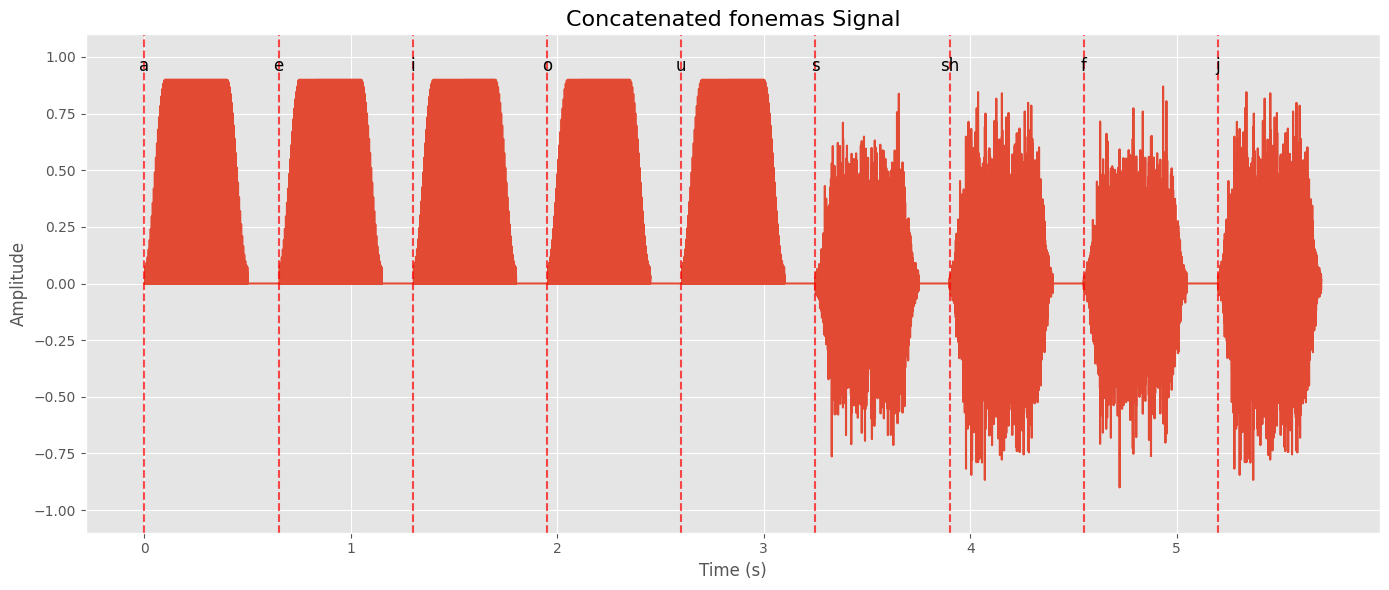

Playing concatenated fonemas:


In [9]:
# Exercise 2(b): Concatenate all fonemas into a single signal for evaluation
fs = 14700  # Sampling Frecuencia (Hz)

# Define the order for concatenating fonemas (vocales then consonantes)
fonema_sequence = vocales + consonantes  # ['a', 'e', 'i', 'o', 'u', 's', 'sh', 'f', 'j']

# Create a short silence (150ms) to insert between fonemas
silence_duracion = 0.15  # 150ms
silence = np.zeros(int(silence_duracion * fs))

# Concatenate all fonemas with silence in between
concatenated_signal = []

print("Concatenating fonemas in the following order:")
for i, fonema in enumerate(fonema_sequence):
    print(f"{i+1}. {fonema}")
    
    # Get the fonema audio (ensuring it has valid values)
    fonema_audio = synthesized_fonemas[fonema]
    valid_audio = np.nan_to_num(fonema_audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    
    # Add fonema to the concatenated signal
    concatenated_signal.extend(valid_audio)
    
    # Add silence after each fonema (except the last one)
    if i < len(fonema_sequence) - 1:
        concatenated_signal.extend(silence)

# Convert to numpy array
concatenated_signal = np.array(concatenated_signal)

# Normalize the final signal
max_amp = np.max(np.abs(concatenated_signal))
if max_amp > 0:
    concatenated_signal = 0.9 * concatenated_signal / max_amp

# Create a time vector for plotting
t = np.arange(len(concatenated_signal)) / fs

# Plot the concatenated signal
plt.figure(figsize=(14, 6))
plt.plot(t, concatenated_signal)

# Add vertical lines and labels to mark where each fonema begins
current_pos = 0
for i, fonema in enumerate(fonema_sequence):
    fonema_start = current_pos / fs
    plt.axvline(x=fonema_start, color='r', linestyle='--', alpha=0.7)
    plt.text(fonema_start, 1.0, fonema, fontsize=12, 
             horizontalalignment='center', verticalalignment='top')
    
    # Update position for next fonema
    current_pos += len(synthesized_fonemas[fonema])
    if i < len(fonema_sequence) - 1:
        current_pos += len(silence)

plt.title('Concatenated fonemas Signal', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(-1.1, 1.1)  # Give space for fonema labels
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the concatenated signal to a wav file
concatenated_filename = f"{output_dir}concatenated_fonemas.wav"
sf.write(concatenated_filename, concatenated_signal, fs)

# Play the concatenated signal (if in Jupyter notebook)
try:
    from IPython.display import Audio, display
    print("Playing concatenated fonemas:")
    display(Audio(concatenated_signal, rate=fs))
except ImportError:
    print(f"Concatenated fonemas saved to: {concatenated_filename}")
    print("Use an audio player to listen to the file for subjective evaluation.")

Filter unstable for a, using alternative approach
Filter unstable for e, using alternative approach
Filter unstable for i, using alternative approach
Filter unstable for o, using alternative approach
Filter unstable for u, using alternative approach
Filter unstable for sh, using alternative approach
Filter unstable for j, using alternative approach


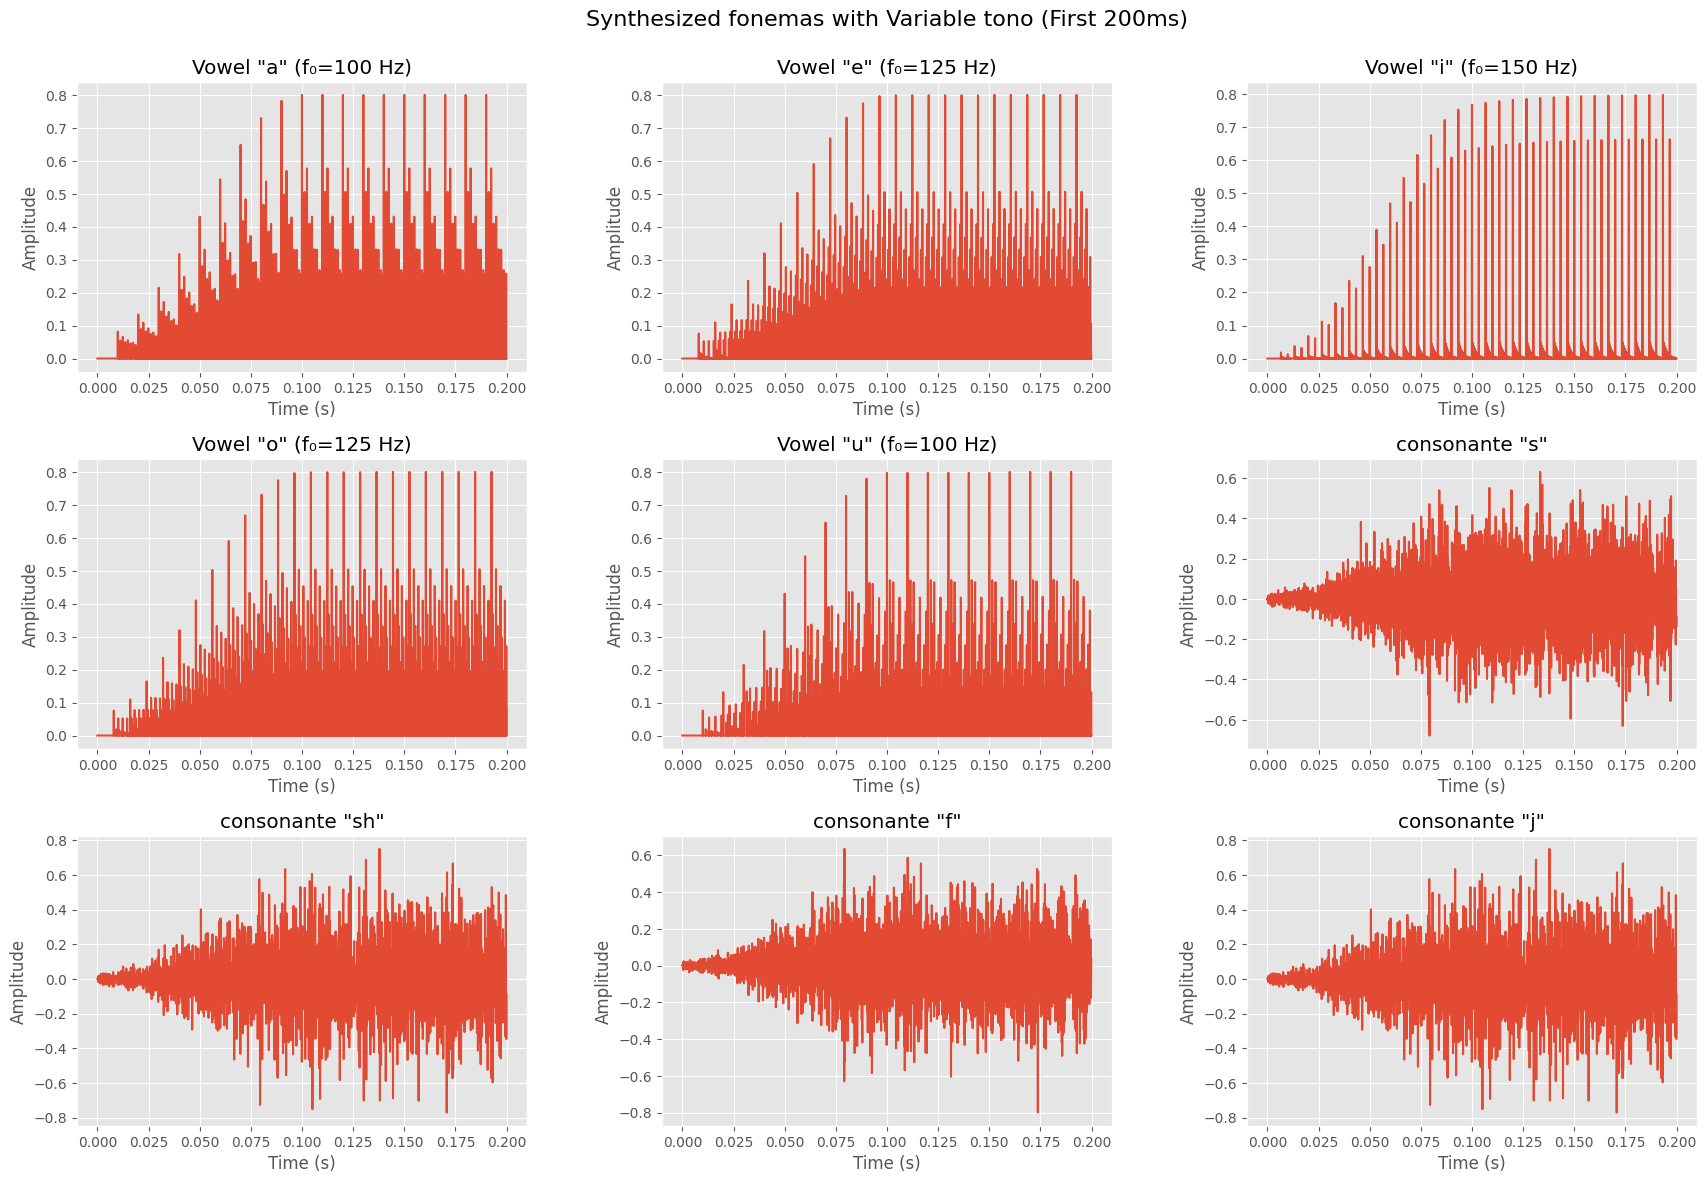

Concatenating fonemas with variable tono in the following order:
1. a (f₀=100 Hz)
2. e (f₀=125 Hz)
3. i (f₀=150 Hz)
4. o (f₀=125 Hz)
5. u (f₀=100 Hz)
6. s
7. sh
8. f
9. j


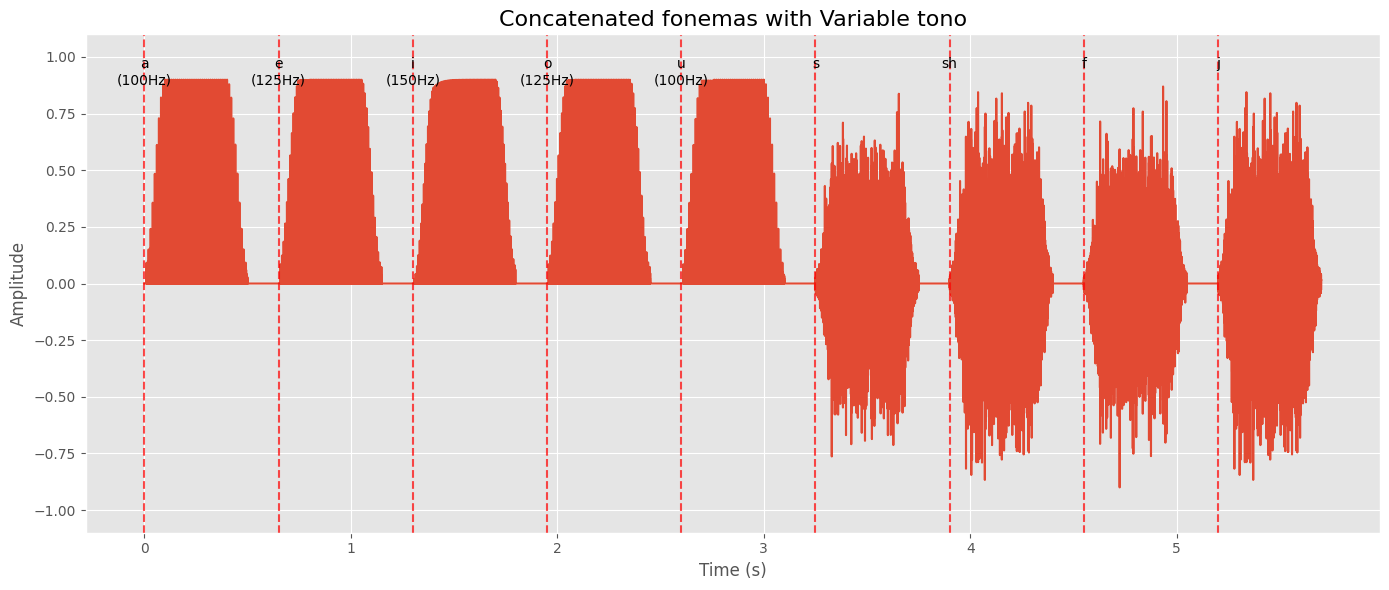

Playing concatenated fonemas with variable tono:


In [10]:
# Exercise 2(c): Synthesize fonemas with different tono for each vowel
fs = 14700  # Sampling Frecuencia (Hz)
duracion = 0.5  # 500 ms
N = int(fs * duracion)  # Number of samples

# Define different tono frequencies for vocales as specified
tono_values = {
    'a': 100,  # 100 Hz
    'e': 125,  # 125 Hz
    'i': 150,  # 150 Hz
    'o': 125,  # 125 Hz
    'u': 100   # 100 Hz
}

# Corrected bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter with safety checks for Nyquist limit"""
    nyquist = 0.5 * fs
    
    # Ensure cutoff frequencies don't exceed Nyquist
    lowcut = min(lowcut, 0.98 * nyquist)
    highcut = min(highcut, 0.98 * nyquist)
    
    # Normalize frequencies to [0, 1] range
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Ensure we have proper ordering
    if high <= low:
        high = min(0.98, low + 0.1)
    
    # Create and apply filter
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data)
    return y

# Dictionary to store synthesized fonemas
synthesized_fonemas = {}

# Create a figure to plot the synthesized fonemas
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Synthesized fonemas with Variable tono (First 200ms)', fontsize=16)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through all fonemas
for i, fonema in enumerate(fonemas):
    if i >= len(axs):  # Ensure we don't exceed available axes
        print(f"Warning: Not enough axes for fonema {fonema}")
        continue
        
    # Get AR coefficients
    coef_afs = coef_a[fonema]
    coef_bf = coef_b[fonema][0]  # Extract scalar value from list
    
    # Create excitation signal based on fonema type
    if fonema in vocales:
        # For vocales: use pulse train with the specific tono for this vowel
        f0 = tono_values[fonema]  # Get specific tono for this vowel
        excitation = gen_pulsos(f0, N, fs)
    else:
        # For consonantes: use white noise
        np.random.seed(42)  # Set seed for reproducibility
        excitation = np.random.randn(N)
    
    # Special direct handling for 's' and 'f' fonemas
    if fonema == 's':
        # For 's': use filtered noise in high Frecuencia range
        synthesized = butter_bandpass_filter(excitation, 3500, 7000, fs)
        # Add some lower Frecuencia energy for better character
        mid_freq_component = butter_bandpass_filter(excitation, 1500, 3000, fs) * 0.3
        synthesized += mid_freq_component
    elif fonema == 'f':
        # For 'f': use filtered noise with broader spectrum
        synthesized = butter_bandpass_filter(excitation, 1500, 6000, fs)
        # Add specific formants to give 'f' character
        formant1 = butter_bandpass_filter(excitation, 1000, 1500, fs) * 0.6
        formant2 = butter_bandpass_filter(excitation, 3000, 5000, fs) * 0.7
        synthesized = 0.5*synthesized + formant1 + formant2
    else:
        # For all other fonemas, use standard AR filtering
        try:
            # Apply AR model using filter
            a_full = np.concatenate(([1.0], coef_afs))
            synthesized = signal.lfilter([coef_bf], a_full, excitation)
            
            # Check for instability
            if not np.all(np.isfinite(synthesized)):
                print(f"Filter unstable for {fonema}, using alternative approach")
                # Create a simplified version using formant filtering
                if fonema in vocales:
                    # Apply formant filters based on vowel characteristics
                    f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[fonema]
                    f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[fonema]
                    
                    # Create formant filters
                    bw1 = f1 * 0.1  # 10% bandwidth
                    bw2 = f2 * 0.1
                    
                    # Apply resonances to pulse train with the specific tono
                    synthesized = signal.lfilter([1.0], [1.0, -0.9], excitation)  # Pre-emphasis
                    
                    # Simple formant synthesis with basic resonators
                    q1 = int(fs / f1)  # Simple comb filter approach
                    q2 = int(fs / f2)
                    
                    resonator1 = np.zeros(N)
                    resonator2 = np.zeros(N)
                    
                    # Apply resonances
                    for n in range(q1, N):
                        resonator1[n] = 0.9 * resonator1[n-q1] + excitation[n]
                        
                    for n in range(q2, N):
                        resonator2[n] = 0.8 * resonator2[n-q2] + excitation[n]
                        
                    synthesized = 0.7 * resonator1 + 0.3 * resonator2
                else:
                    # For unstable consonantes, use filtered noise
                    synthesized = butter_bandpass_filter(excitation, 1000, 4000, fs)
        except Exception as e:
            print(f"Error processing {fonema}: {str(e)}")
            synthesized = np.zeros(N)  # Fallback to silence
    
    # Normalize to reasonable amplitude
    max_amp = np.max(np.abs(synthesized))
    if max_amp > 0:
        synthesized = 0.8 * synthesized / max_amp
    
    # Apply edge smoothing with 20% transition
    synthesized = suavizar_bordes(synthesized, fade=20)
    
    # Store the synthesized fonema
    synthesized_fonemas[fonema] = synthesized
    
    # Display first 200ms
    display_samples = int(0.2 * fs)
    t = np.arange(display_samples) / fs
    
    # Clean any remaining invalid values
    plotting_data = np.nan_to_num(synthesized[:display_samples], nan=0.0)
    plotting_data = np.clip(plotting_data, -1, 1)
    
    # Plot the fonema
    axs[i].plot(t, plotting_data)
    if fonema in vocales:
        axs[i].set_title(f'Vowel "{fonema}" (f₀={tono_values[fonema]} Hz)')
    else:
        axs[i].set_title(f'consonante "{fonema}"')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True)

# Adjust layout and display
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

# Save the synthesized fonemas to audio files
output_dir = "./variable_tono/"
os.makedirs(output_dir, exist_ok=True)

for fonema, audio in synthesized_fonemas.items():
    # Ensure we have valid data before saving
    valid_audio = np.nan_to_num(audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    sf.write(f"{output_dir}{fonema}_synth.wav", valid_audio, fs)

# Now concatenate all fonemas as in part (b)
# Define the order for concatenating fonemas (vocales then consonantes)
fonema_sequence = vocales + consonantes

# Create a short silence (150ms) to insert between fonemas
silence_duracion = 0.15  # 150ms
silence = np.zeros(int(silence_duracion * fs))

# Concatenate all fonemas with silence in between
concatenated_signal = []

print("Concatenating fonemas with variable tono in the following order:")
for i, fonema in enumerate(fonema_sequence):
    if fonema in vocales:
        print(f"{i+1}. {fonema} (f₀={tono_values[fonema]} Hz)")
    else:
        print(f"{i+1}. {fonema}")
    
    # Get the fonema audio (ensuring it has valid values)
    fonema_audio = synthesized_fonemas[fonema]
    valid_audio = np.nan_to_num(fonema_audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    
    # Add fonema to the concatenated signal
    concatenated_signal.extend(valid_audio)
    
    # Add silence after each fonema (except the last one)
    if i < len(fonema_sequence) - 1:
        concatenated_signal.extend(silence)

# Convert to numpy array
concatenated_signal = np.array(concatenated_signal)

# Normalize the final signal
max_amp = np.max(np.abs(concatenated_signal))
if max_amp > 0:
    concatenated_signal = 0.9 * concatenated_signal / max_amp

# Create a time vector for plotting
t = np.arange(len(concatenated_signal)) / fs

# Plot the concatenated signal
plt.figure(figsize=(14, 6))
plt.plot(t, concatenated_signal)

# Add vertical lines and labels to mark where each fonema begins
current_pos = 0
for i, fonema in enumerate(fonema_sequence):
    fonema_start = current_pos / fs
    plt.axvline(x=fonema_start, color='r', linestyle='--', alpha=0.7)
    
    # Add tono information to vowel labels
    if fonema in vocales:
        label = f'{fonema}\n({tono_values[fonema]}Hz)'
    else:
        label = fonema
    
    plt.text(fonema_start, 1.0, label, fontsize=10, 
             horizontalalignment='center', verticalalignment='top')
    
    # Update position for next fonema
    current_pos += len(synthesized_fonemas[fonema])
    if i < len(fonema_sequence) - 1:
        current_pos += len(silence)

plt.title('Concatenated fonemas with Variable tono', fontsize=16)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.ylim(-1.1, 1.1)  # Give space for fonema labels
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the concatenated signal to a wav file
concatenated_filename = f"{output_dir}concatenated_variable_tono.wav"
sf.write(concatenated_filename, concatenated_signal, fs)

# Play the concatenated signal (if in Jupyter notebook)
try:
    from IPython.display import Audio, display
    print("Playing concatenated fonemas with variable tono:")
    display(Audio(concatenated_signal, rate=fs))
except ImportError:
    print(f"Concatenated fonemas saved to: {concatenated_filename}")
    print("Use an audio player to listen to the file for subjective evaluation.")

In [57]:
rick_roll_sequence = ['e','e','o','a','i','i','u','u','a','a','a','e','e','o','a','e','e','u','u','a','a','a','e','e','o','a','a','a','a','a','a','a','a','a','a','a','i','i','e','e','e','u']
rick_roll_tones = {0:97.999,1:110,2:130.81,3:110,4:164.81,5:0.01,6:164.81,7:0.01,8:146.83,9:0.01,10:0.01,11:97.999,12:110,13:130.81,14:110,15:146.83,16:0.01,17:146.83,18:0.01,19:130.81,20:123.47,21:110,22:97.999,23:110,24:130.81,25:110,26:130.81,27:0.01,28:0.01,29:146.83,30:0.01,31:123.47,32:0.01,33:97.999,34:0.01,35:0.01,36:97.999,37:0.01,38:146.83,39:0.01,40:0.01,41:130.81}

silence_duration = 0.00
silence = np.zeros(int(silence_duration * fs))
concatenated_signal = []

for i, phoneme in enumerate(rick_roll_sequence):
    if phoneme in vocales:
        melody_tone = rick_roll_tones[i]        
        coef_afs = coef_a[phoneme]
        coef_bf = coef_b[phoneme][0]
        excitation = gen_pulsos(melody_tone, N, fs)
        a_full = np.concatenate(([1.0], coef_afs))
        synthesized = signal.lfilter([coef_bf], a_full, excitation)
        
        if not np.all(np.isfinite(synthesized)):
            f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[phoneme]
            f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[phoneme]
            
            synthesized = signal.lfilter([1.0], [1.0, -0.9], excitation)
            
            q1 = int(fs / f1)
            q2 = int(fs / f2)
            
            resonator1 = np.zeros(N)
            resonator2 = np.zeros(N)
            
            for n in range(q1, N):
                resonator1[n] = 0.9 * resonator1[n-q1] + excitation[n]
                
            for n in range(q2, N):
                resonator2[n] = 0.8 * resonator2[n-q2] + excitation[n]
                
            synthesized = 0.7 * resonator1 + 0.3 * resonator2
        
        max_amp = np.max(np.abs(synthesized))
        if max_amp > 0:
            synthesized = 0.8 * synthesized / max_amp
        
        audio_sample = suavizar_bordes(synthesized, fade=20)
    else:
        audio_sample = synthesized_fonemas[phoneme]
    
    valid_audio = np.nan_to_num(audio_sample, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    
    concatenated_signal.extend(valid_audio)

secret_signal_filename = f"{output_dir}secret_signal_melody.wav"
sf.write(secret_signal_filename, concatenated_signal, fs)

speed_factor = 3.5
resampled_length = int(len(concatenated_signal) / speed_factor)
faster_signal = signal.resample(concatenated_signal, resampled_length)

sf.write(secret_signal_filename, faster_signal, fs)

display(Audio(faster_signal, rate=fs))